# Imports

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd

# Hämta datan

In [35]:
iris = pd.read_csv("iris.csv")
mallcustomers = pd.read_csv("Mall_Customers.csv")

# Iris

In [36]:
# Vi kikar lite på iris datasetet
print(len(iris))
iris.head()

150


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [37]:
# Vi kikar efter saknande värden
missing_values = iris.isna().sum()
print("Missing values count: ", missing_values.sum())

Missing values count:  0


Inga värden saknas i alla fall.

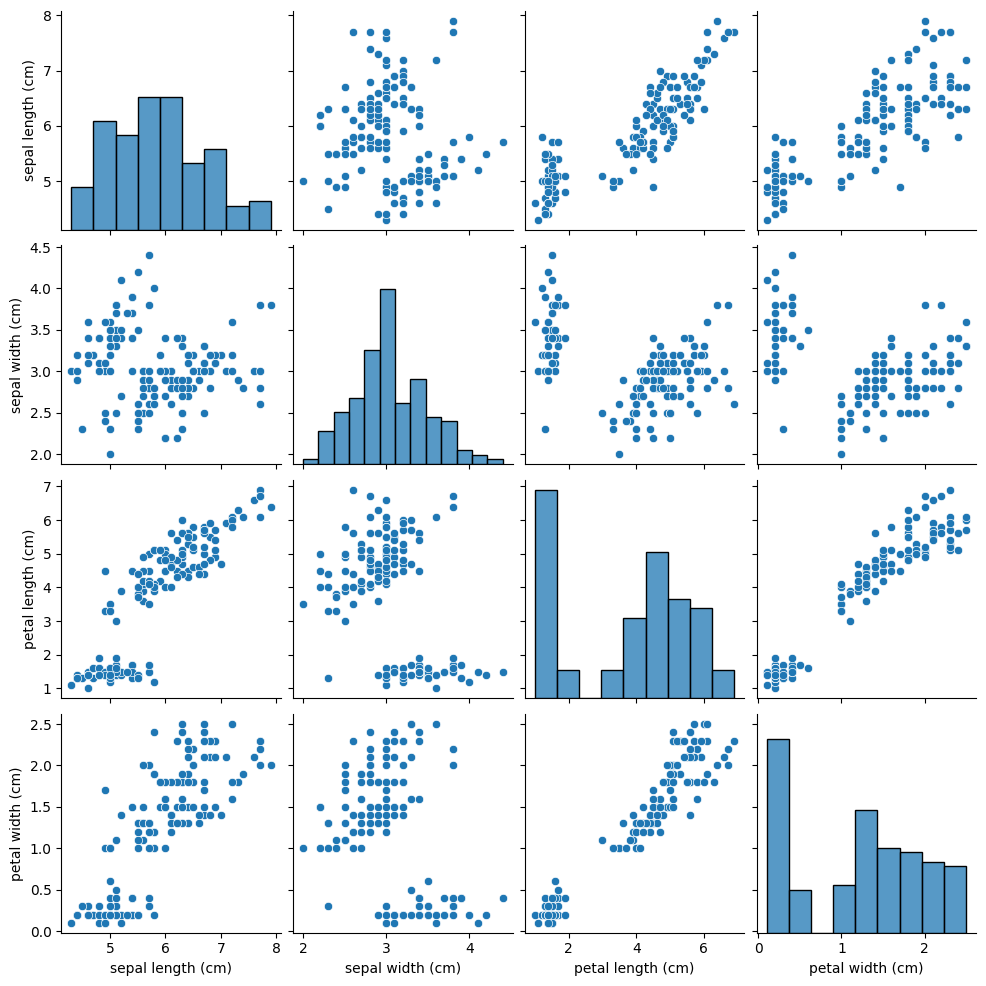

In [38]:
sns.pairplot(iris)
plt.show()

# Mall Customers

In [39]:
# Vi kikar lite på mall customers datasetet
print(len(mallcustomers))
mallcustomers.head()

200


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [40]:
# Vi kan ta bort customer ID, den kolumnen har ingen betydelse för våran analys
mallcustomers = mallcustomers.iloc[:,1:]
mallcustomers.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


Ett annat problem är att gender är strängar just nu, vi behöver konvertera det till tal för att det ska fungera som en vektor.

In [41]:
# Konvertera strängar för kön till tal
mallcustomers["Gender"] = mallcustomers["Gender"].map({"Male": 1, "Female": 2})
mallcustomers.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,2,20,16,6
3,2,23,16,77
4,2,31,17,40


# Min egna K-Means

In [55]:
# OLD
class MyKMeans:
    def __init__(self, k:int, random_state:int=None) -> None:
        """ My epic K-Means algorithm! """
        self._k = k
        self._random_state = random_state

    def _create_rand_point(self, data:pd.DataFrame):
        """ Skapa en slumpmässig punkt som skulle passa in i datasetet """

        n_dimensions = data.shape[1]

        # Vi bestämmer om punkten ska vara float eller int igenom att kolla på detta attribut
        attr_test = data.iloc[1, :1].values[0]

        if isinstance(attr_test, np.float64):
            # Float
            rand_point = np.array([np.float64(0) for _ in range(n_dimensions)]) # Gör en vektor med floats
            rand_func = rnd.uniform
        elif isinstance(attr_test, np.int64):
            # Integer
            rand_point = np.array([np.int64(0) for _ in range(n_dimensions)]) # Gör en vektor med ints
            rand_func = rnd.randint
        else:
            # Något annat skräp
            raise ValueError("Datan får endast innehålla 'np.float64' eller 'np.int64'!")

        for i in range(1, n_dimensions+1):
            attr_min = data.iloc[:, :i].values.min() # Min värdet för attributet
            attr_max = data.iloc[:, :i].values.max() # Max värdet för attributet
            rand_point[i-1] = rand_func(attr_min, attr_max) # Vi vill ha ett slumpmässigt värde som skulle passa det här attributet

        return rand_point

    def cluster(self, data:pd.DataFrame):
        if not self._random_state is None:
            rnd.seed(self._random_state)

        n_centeroids = self._k
        used_points_indexes = [] # Index för punkter som bedöms vara närmast en centroid
        datalen = len(data)

        # Skapa centeroiderna
        centeroids = [self._create_rand_point(data) for _ in range(n_centeroids)]

        # Lista för kluster
        clusters_indexes_list = [[] for _ in range(n_centeroids)]
        clusters_list = [[] for _ in range(n_centeroids)]


        iterations = 50
        for _ in range(iterations):

            # Hitta närmsta punkt för varje centeroid
            for i, centeroid in enumerate(centeroids):
                mindist = None
                nearest = None
                nearest_idx = None

                for j, point in enumerate(data.values):

                    # Den här punkten har vi redan delat in i ett kluster
                    if j in used_points_indexes:
                        continue

                    dist = np.linalg.norm(point - centeroid)
                    if (mindist is None or dist < mindist):
                        mindist = dist
                        nearest = point
                        nearest_idx = j

                clusters_list[i].append(nearest)
                clusters_indexes_list[i].append(nearest_idx)
                used_points_indexes.append(nearest_idx)
    
            # Flytta centreroiderna till average positionen för respektive kluster
            for i, clist in enumerate(clusters_list):
                centeroids[i] = np.mean(clist, axis=0)


        clusters_final = [0 for _ in range(datalen)]
        for i, indexlist in enumerate(clusters_indexes_list):
            cluster_nr = i+1

            for point_idx in indexlist:
                clusters_final[point_idx] = cluster_nr

        return clusters_final
            

In [ ]:
class MyKMeans:
    def __init__(self, k:int, random_state:int=None) -> None:
        """ My epic K-Means algorithm! """
        self._k = k
        self._random_state = random_state

    def _create_rand_point(self, data:pd.DataFrame):
        """ Skapa en slumpmässig punkt som skulle passa in i datasetet """

        n_dimensions = data.shape[1]

        # Vi bestämmer om punkten ska vara float eller int igenom att kolla på detta attribut
        attr_test = data.iloc[1, :1].values[0]

        if isinstance(attr_test, np.float64):
            # Float
            rand_point = np.array([np.float64(0) for _ in range(n_dimensions)]) # Gör en vektor med floats
            rand_func = rnd.uniform
        elif isinstance(attr_test, np.int64):
            # Integer
            rand_point = np.array([np.int64(0) for _ in range(n_dimensions)]) # Gör en vektor med ints
            rand_func = rnd.randint
        else:
            # Något annat skräp
            raise ValueError("Datan får endast innehålla 'np.float64' eller 'np.int64'!")

        for i in range(1, n_dimensions+1):
            attr_min = data.iloc[:, :i].values.min() # Min värdet för attributet
            attr_max = data.iloc[:, :i].values.max() # Max värdet för attributet
            rand_point[i-1] = rand_func(attr_min, attr_max) # Vi vill ha ett slumpmässigt värde som skulle passa det här attributet

        return rand_point

    def cluster(self, data:pd.DataFrame):

        # Hantera random state
        if not self._random_state is None:
            rnd.seed(self._random_state)

        # Variabler
        n_centeroids = self._k
        used_points_indexes = [] # Index för punkter som bedöms vara närmast en centroid
        datalen = len(data)


        # Skapa centeroiderna
        centeroids = [self._create_rand_point(data) for _ in range(n_centeroids)]


        # Lista för kluster
        clusters_list = [[] for _ in range(n_centeroids)]


        # Hitta närmsta centeroid för varje punkt
        clusters_final = []
        for i, point in enumerate(data.values):
            mindist = None
            cluster_nr = None


            for j, centeroid in enumerate(centeroids):

                dist = np.linalg.norm(point - centeroid)
                if (mindist is None or dist < mindist):
                    mindist = dist
                    cluster_nr = j+1

            if cluster_nr is None:
                raise Exception("BLYATTTTTTTT")
            

            clusters_final.append(nearest_cent_idx)





            # clusters_list[i].append(nearest)
            # clusters_indexes_list[i].append(nearest_idx)
            # used_points_indexes.append(nearest_idx)

        # Flytta centreroiderna till average positionen för respektive kluster
        for i, clist in enumerate(clusters_list):
            centeroids[i] = np.mean(clist, axis=0)


        # clusters_final = [0 for _ in range(datalen)]
        # for i, indexlist in enumerate(clusters_indexes_list):
        #     cluster_nr = i+1

        #     for point_idx in indexlist:
        #         clusters_final[point_idx] = cluster_nr

        # return clusters_final
            

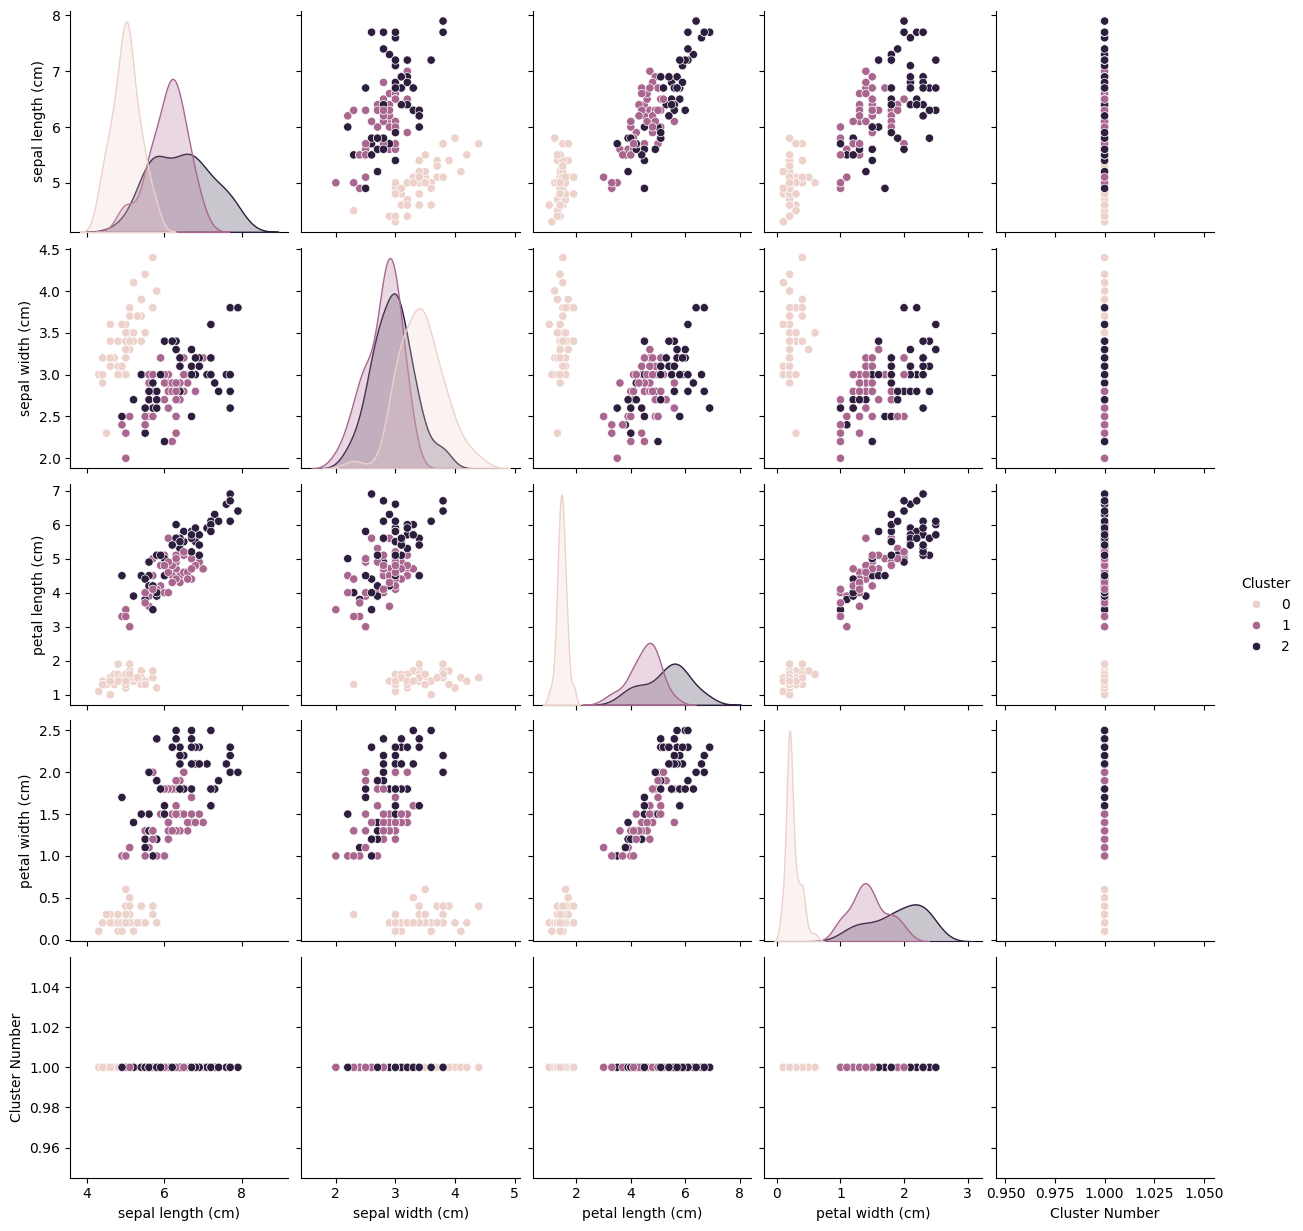

In [59]:
kmeans = MyKMeans(k=2)
clusters = kmeans.cluster(iris)
iris["Cluster"] = clusters
sns.pairplot(iris, hue="Cluster")
plt.show()